## import bibliotek ##

In [24]:
# na vdi nie ma zainstalowanej biblioteki ccxt. aby zainstalować, odkomentuj poniższy wiersz:
# !pip install ccxt
import ccxt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## ustawienia ##

In [25]:
# Pobieranie danych za pomocą CCXT
exchange = ccxt.binance()
def fetch_ohlcv(symbol, timeframe='1s', since=None):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)
    dataframe = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='ms')
    dataframe.set_index('timestamp', inplace=True)
    return dataframe

# Ustawienia
n_sec = 1800
symbols = ['BTC/USDT', 'ETH/USDT', 'DOT/USDT', 'ADA/USDT', 'SOL/USDT']
since = exchange.parse8601((datetime.utcnow() - timedelta(seconds=n_sec)).isoformat())
dataframes = [fetch_ohlcv(symbol, since=since) for symbol in symbols]

# Łączenie danych w jeden DataFrame
merged_df = pd.concat([df['close'].rename(symbol.split('/')[0]) for df, symbol in zip(dataframes, symbols)], axis=1)
merged_df.fillna(method='ffill', inplace=True)

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_4060\244030131.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


## uczenie i wyświetlanie wyników ##

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


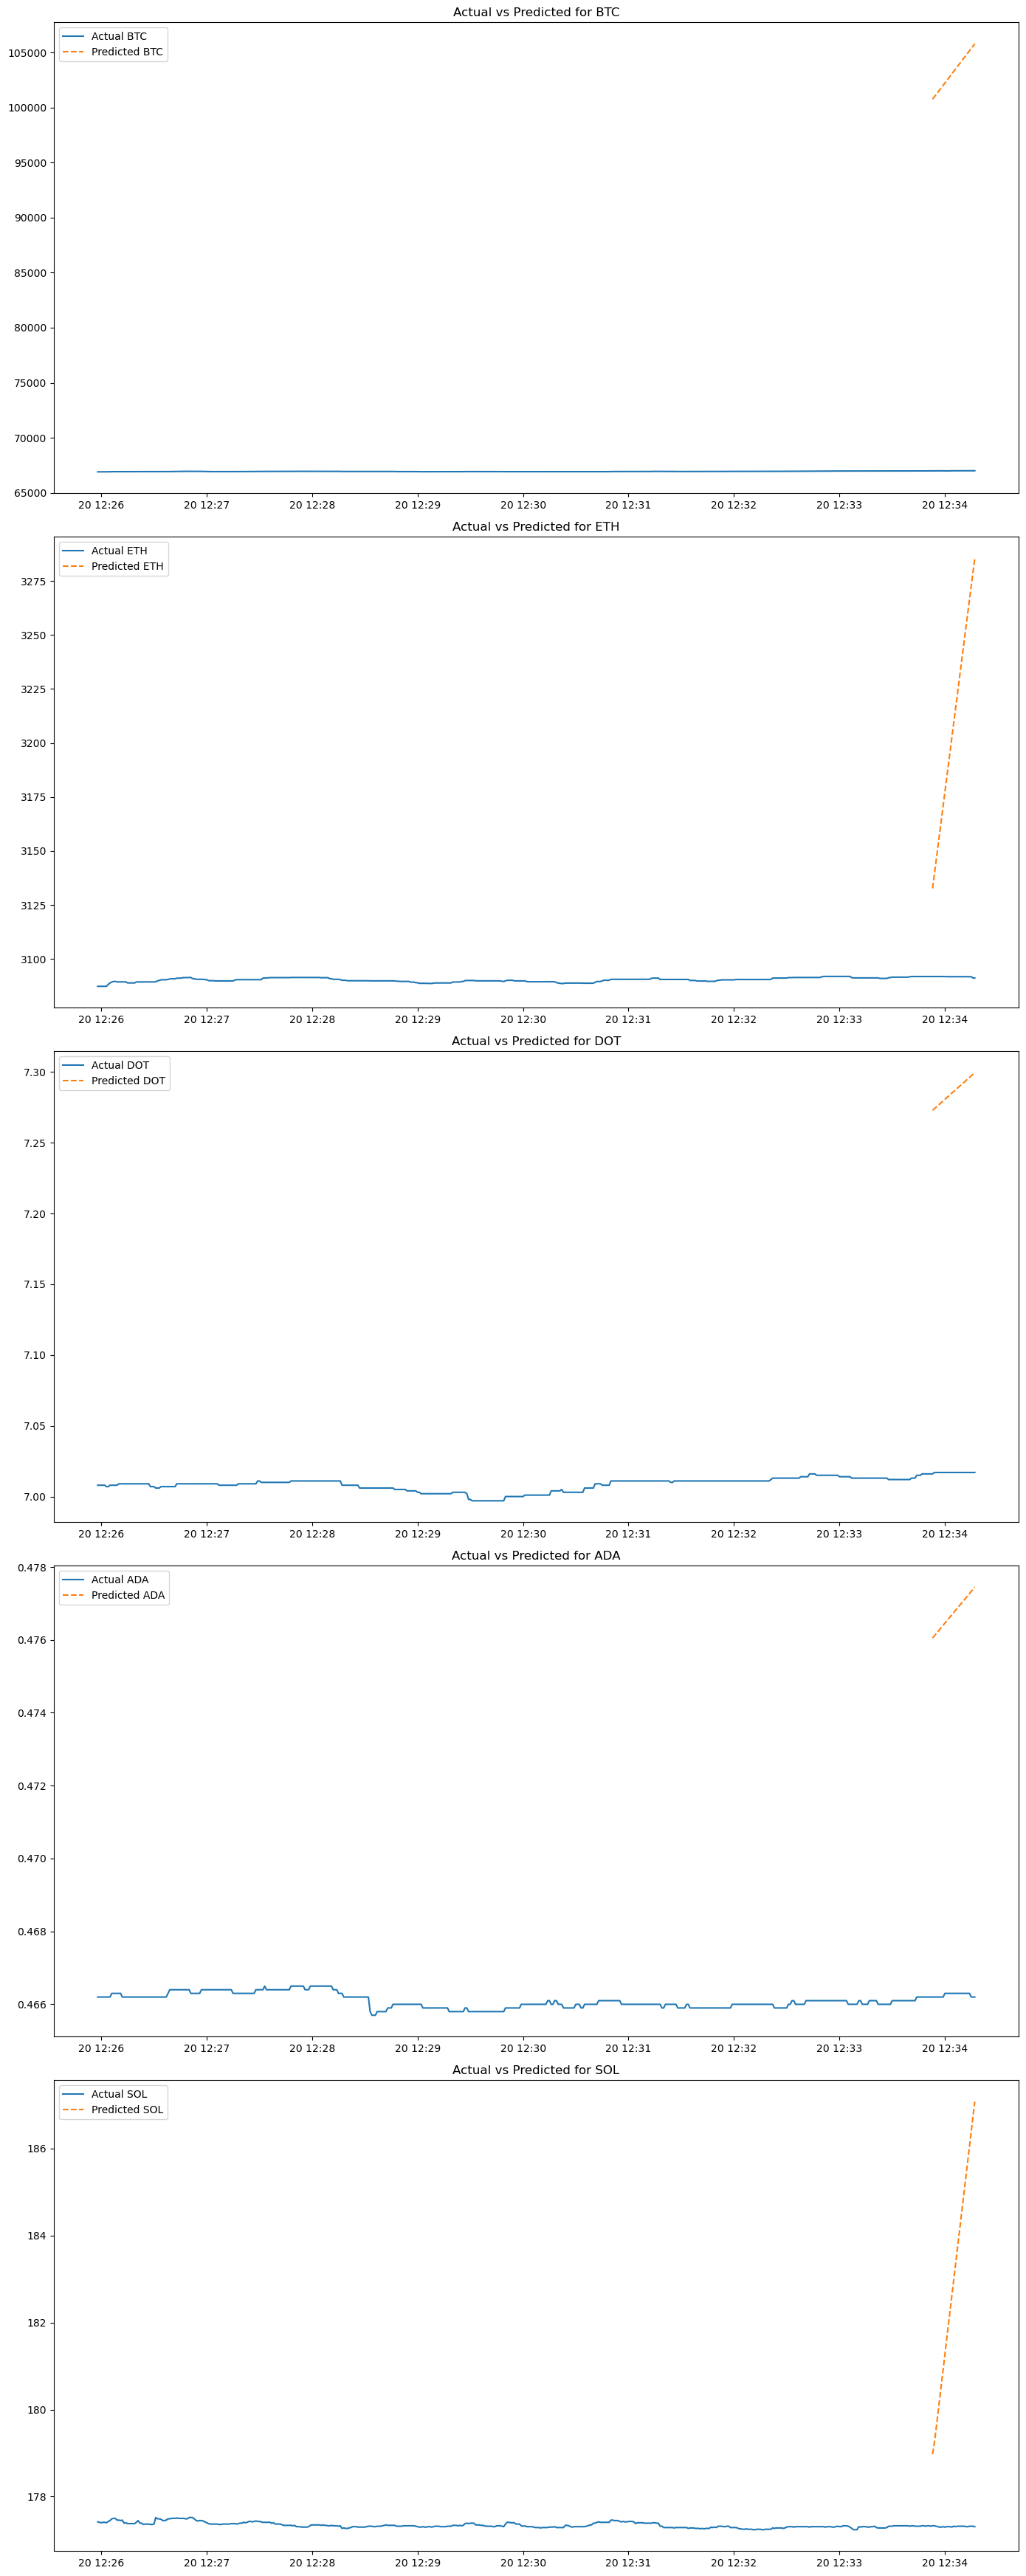

In [27]:
# Lista do przechowywania modeli MLP dla każdej kryptowaluty
models = {}

# Tworzenie subplots
fig, axes = plt.subplots(nrows=len(symbols), ncols=1, figsize=(14, 7 * len(symbols)))

# Trenowanie i przewidywanie dla każdej kryptowaluty osobno
for i, col in enumerate(merged_df.columns):     # Skalowanie danych
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Tworzenie i trenowanie modelu MLP dla danej kryptowaluty
    model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
    model.fit(X_train, y_train)
    models[col] = model

    # Przewidywanie cen
    y_pred = model.predict(X_test)

    # Tworzenie DataFrame z przewidywanymi cenami
    predictions_df = pd.DataFrame(y_pred, index=merged_df.index[len(X_train):], columns=[col])

    # Wyświetlanie wyników na osobnych wykresach
    axes[i].plot(merged_df.index, merged_df[col], label=f"Actual {col}")
    axes[i].plot(predictions_df.index, predictions_df[col], linestyle='dashed', label=f"Predicted {col}")
    axes[i].set_title(f"Actual vs Predicted for {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

# poprzedni kod #

In [20]:
# !pip install ccxt
import ccxt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from datetime import datetime, timedelta

exchange = ccxt.binance()
# Pobieranie danych za pomocą CCXT
def fetch_ohlcv(symbol, timeframe='1s', since=None):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)
    dataframe = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='ms')
    dataframe.set_index('timestamp', inplace=True)
    return dataframe

# Ustawienia
symbols = ['BTC/USDT', 'ETH/USDT', 'DOT/USDT', 'ADA/USDT', 'SOL/USDT']
# since = exchange.parse8601('2024-05-01T00:00:00Z')
since = exchange.parse8601((datetime.utcnow() - timedelta(seconds=1800)).isoformat())
dataframes = [fetch_ohlcv(symbol, since=since) for symbol in symbols]

# Łączenie danych w jeden DataFrame
merged_df = pd.concat([df['close'].rename(symbol.split('/')[0]) for df, symbol in zip(dataframes, symbols)], axis=1)
merged_df.fillna(method='ffill', inplace=True)

# Przygotowanie danych do trenowania modelu
X = merged_df[:-1].values
y = merged_df[1:].values

# Podział danych na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Skalowanie danych
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Tworzenie i trenowanie modelu MLP
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

# Przewidywanie cen
y_pred = model.predict(X_test_scaled)

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_4060\4240997208.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                              BTC          ETH       DOT       ADA         SOL
timestamp                                                                     
2024-05-20 12:16:20  58367.601823  3465.501792  7.947601  3.922808  192.298193
2024-05-20 12:16:21  58361.422805  3465.128838  7.926823  3.916210  192.258976
2024-05-20 12:16:22  64041.024912  3802.105520  7.723517  4.181448  210.159279
2024-05-20 12:16:23  56897.584550  3378.090712  7.064073  3.750888  187.079617
2024-05-20 12:16:24  56862.839627  3376.034877  7.073729  3.752234  186.972261


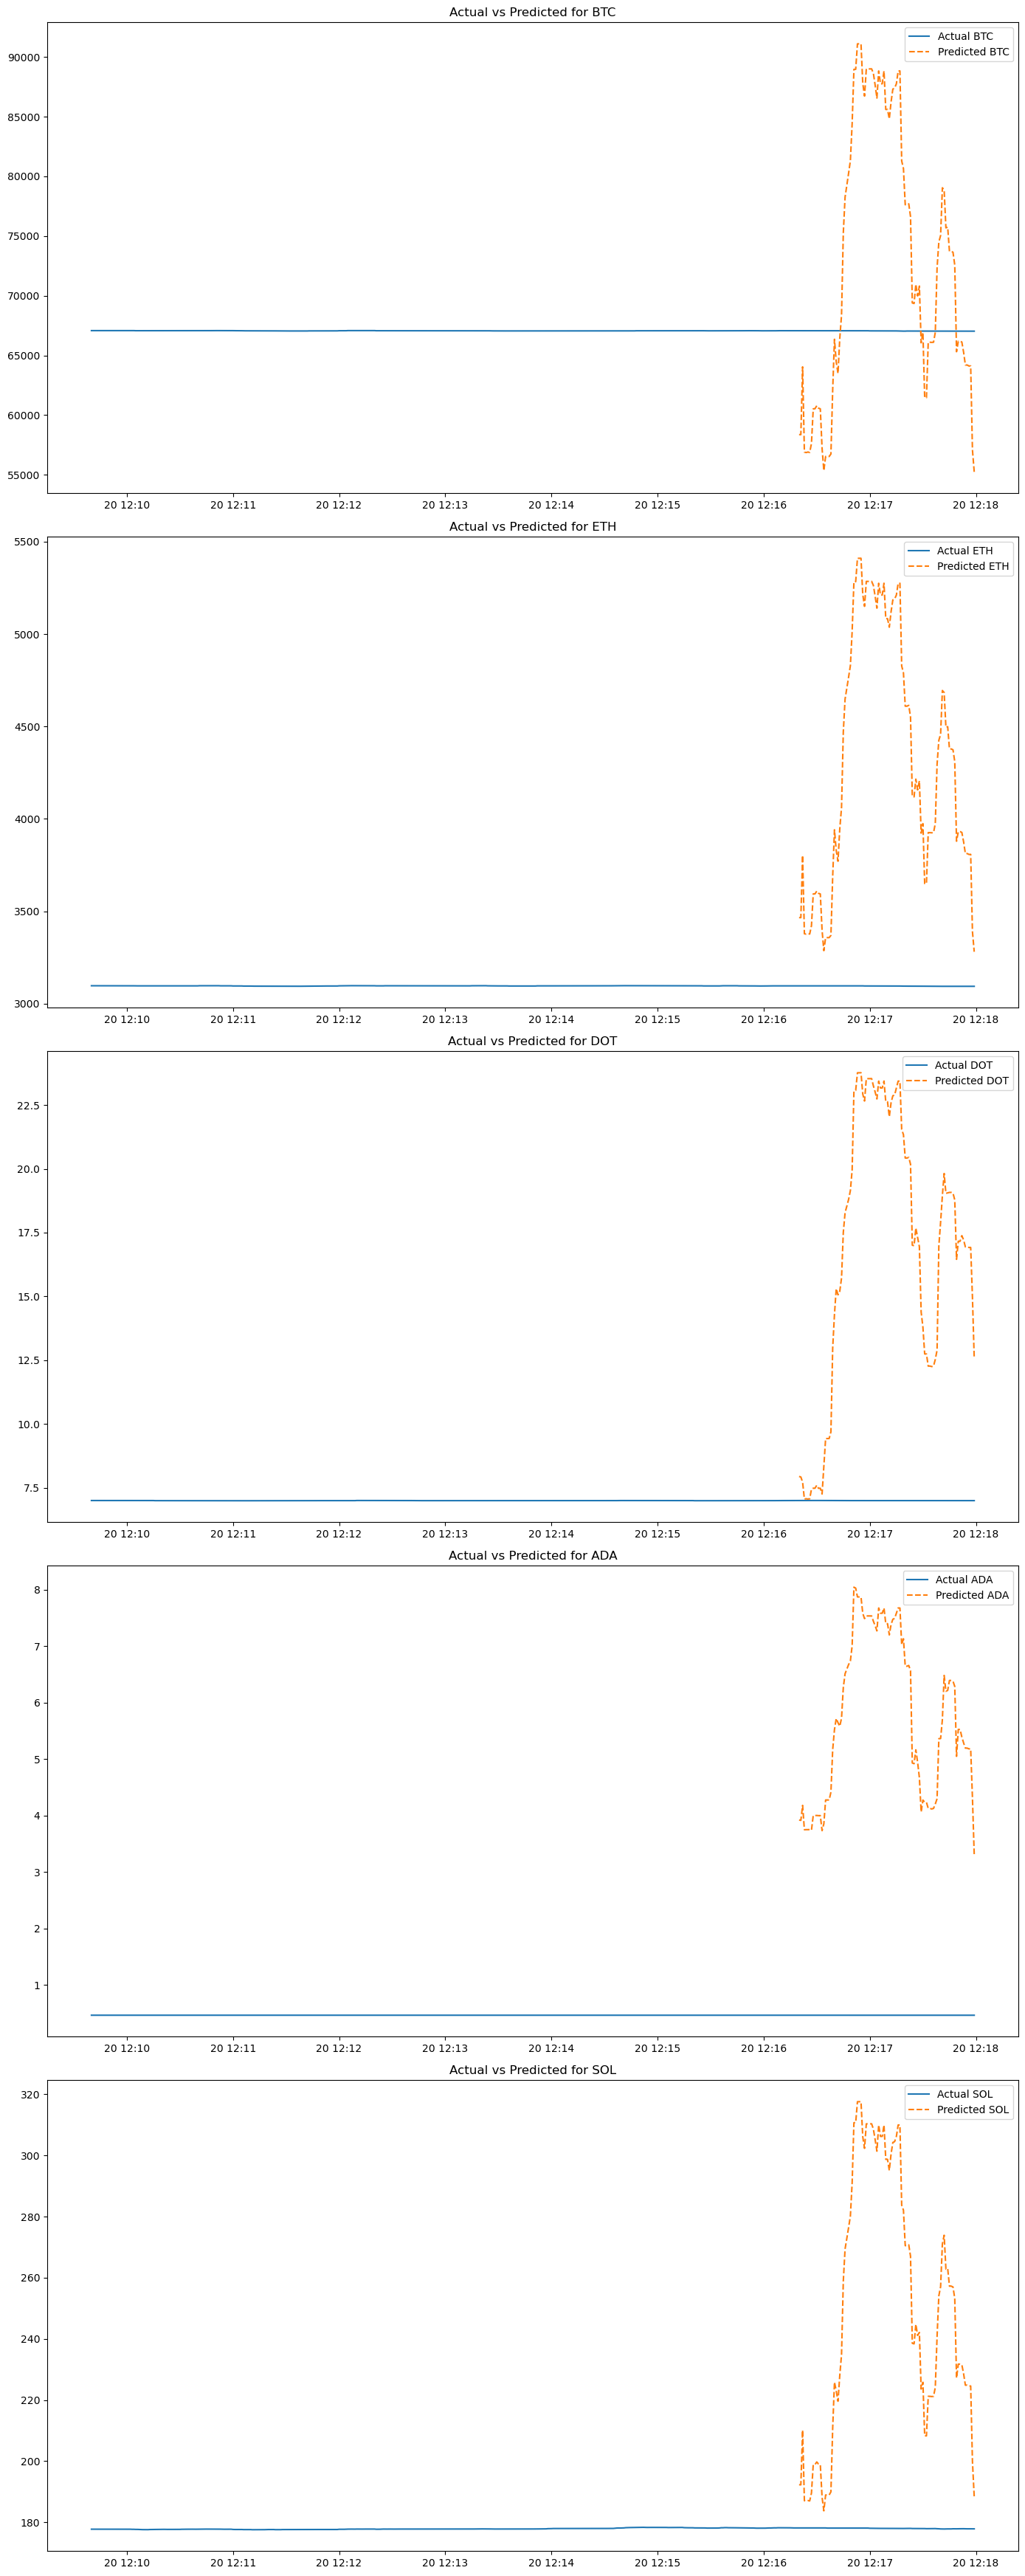

In [21]:
# Wyświetlanie wyników

predictions_df = pd.DataFrame(y_pred, index=merged_df.index[len(X_train)+1:], columns=merged_df.columns)
print(predictions_df.head())

# Ewentualne wykresy porównawcze
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(symbols), ncols=1, figsize=(14, 7 * len(symbols)))
for i, col in enumerate(merged_df.columns):
    axes[i].plot(merged_df.index, merged_df[col], label=f"Actual {col}")
    axes[i].plot(predictions_df.index, predictions_df[col], linestyle='dashed', label=f"Predicted {col}")
    axes[i].set_title(f"Actual vs Predicted for {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

